## Student: Arina Odnoblyudova; Student number: 1011616

## Libraries

In [159]:
import re
import nltk
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from string import punctuation
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import normalized_mutual_info_score, silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD, PCA
from scipy.cluster.hierarchy import ward, dendrogram, fcluster
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

import random

## Download resources

In [160]:
#Uncomment to download resources
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('wordnet')
#!pip install bertopic
#!pip install sentence-transformers

## 0. Data download and exploration

In [161]:
df = pd.read_csv('abstractdata5.csv', sep='#', header=None)
df.columns = ['id','class','title','abstract']
true_classes = list(df['class'])

In [162]:
print('There are: ', df.shape[0], 'texts in data.')

There are:  1332 texts in data.


The most common class is the first one. However, we cannot say that the number of texts in the classes is too uneven, all classes are represented by a sufficient number of texts in the dataset.

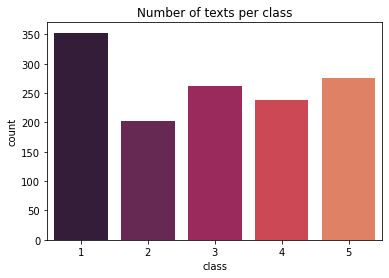

In [163]:
fig, ax = plt.subplots()
sns.countplot(x="class", data=df, axes=ax, palette=sns.color_palette("rocket"))
plt.title("Number of texts per class")
plt.show()

It'd be useful to look at representatives of each class.

**First class**

In [164]:
df[df['class']==1].iloc[0,2]

'Anomaly detection in wide area imagery [Geniş alan görüntülerinde anomali tespiti]'

In [165]:
df[df['class']==1].iloc[0,3][:500]

'This study is about detecting anomalies in wide area imagery collected from an aircraft. The set of anomalies have been identified as anything out of the normal course of action. For this purpose, two different data sets were used and the experiments were carried out on these data sets. For anomaly detection, a convolutional neural network model that tries to generate the next image using past images is designed. The images were pre-processed before being given to the model. Anomaly detection is'

**Second class**

In [166]:
df[df['class']==2].iloc[0,2]

'Extracting multiple viewpoint models from relational databases'

In [167]:
df[df['class']==2].iloc[0,3][:500]

'Much time in process mining projects is spent on finding and understanding data sources and extracting the event data needed. As a result, only a fraction of time is spent actually applying techniques to discover, control and predict the business process. Moreover, current process mining techniques assume a single case notion. However, in real-life processes often different case notions are intertwined. For example, events of the same order handling process may refer to customers, orders, order '

**Third class**

In [168]:
df[df['class']==3].iloc[0,2]

'Mask then classify: multi-instance segmentation for surgical instruments'

In [169]:
df[df['class']==3].iloc[0,3][:500]

'Purpose: The detection and segmentation of surgical instruments has been a vital step for many applications in minimally invasive surgical robotics. Previously, the problem was tackled from a semantic segmentation perspective, yet these methods fail to provide good segmentation maps of instrument types and do not contain any information on the instance affiliation of each pixel. We propose to overcome this limitation by using a novel instance segmentation method which first masks instruments and'

**Forth class**

In [170]:
df[df['class']==4].iloc[0,2]

'Post-quantum secure multi-party private set-intersection in star network topology'

In [171]:
df[df['class']==4].iloc[0,3][:500]

'In many realistic scenarios, participants wish to perform some secret set operations such as intersection, union, cardinality of intersection, etc. on their private data sets. Private Set Intersection (PSI) plays a major role in addressing such problems. PSI is one of the widely used secure multi-party computation technique that allows the participants to securely compute the intersection of their private input sets and nothing beyond that. It is generally executed between two parties. When the '

**Fifth class**

In [172]:
df[df['class']==5].iloc[0,2]

'Towards an energy efficient code generator for mobile phones'

In [173]:
df[df['class']==5].iloc[0,3][:500]

"Using a smartphone become the part of our everyday life in the last few years. These devices can help us in many areas of life (sport, job, weather etc.), but sometimes can be also very annoying because of the battery life time. That is why it is very important to find solutions, which can reduce the energy consumption of the smartphones. One possible method is the 'computation offloading' where a part of the processes are executed on a remote device (e.g. in the cloud). A lot of example has alr"

Perhaps it is premature, but all topics are in one way or another related to technology, IT, data processing, as seen from the texts.

## 1. Baseline solution

### 1.1 Data preprocessing

Combination of title and abstract.

In [174]:
df1 = df.copy()
df1['title_text'] = df1['title'] + " " + df1['abstract']
df1.drop(['title','abstract'], axis=1, inplace=True)

Tokenization. A numpy ndarray class instance is made of the size (1332,). Where each row - a list, representing the text. It is rather convenient to operate with this matrix.

In [175]:
texts = pd.Series.to_numpy(df1['title_text'].apply(word_tokenize))

Removement of stopwords.

In [176]:
stop_words = set(stopwords.words('english'))

# Punctuation is included in the stop words set.
stop_words.update(punctuation)
stop_words.add("...")
stop_words.add(".")

print('Stop words we are using from NLTK:')
print(stop_words)

Stop words we are using from NLTK:
{'\\', '"', ')', 'she', '{', 'd', 'i', '_', 'with', 'who', 'a', 'against', 'ourselves', "mightn't", 'won', 'had', ',', 'my', 'too', '.', "you'll", 'couldn', 'we', "you've", 'through', 'any', 'there', 's', 'them', 't', 'it', 've', '?', 'off', 'doing', 'about', 'hasn', '`', 'yourselves', 'up', 'should', 'just', 'so', 'after', 'other', 'm', ':', "wasn't", "haven't", 'did', 'by', 'wasn', 'same', 'ours', 'aren', 'yours', '...', 'but', 'while', 'has', "mustn't", 'being', 'further', 'don', "should've", 'do', '^', "you're", '$', 'no', 'you', 'than', 'this', 'ma', 'is', 'whom', 'was', "didn't", '#', 'doesn', "you'd", 'the', 'over', 'if', 'some', 're', "weren't", 'having', 'himself', 'theirs', 'in', "that'll", 'once', 'between', 'our', 'he', 'then', 'that', 'during', '@', 'its', 'yourself', "she's", 'be', 'before', 'only', "couldn't", "hadn't", 'haven', 'were', '%', 'hers', '}', 'for', '=', 'will', 'your', '<', 'her', '!', 'me', '~', 'both', '[', 'wouldn', 'the

In [177]:
texts_stage1 = []
for text in texts:
    filtered_text = [w for w in text if not w.lower() in stop_words]
    texts_stage1.append(filtered_text)

Stemming of the remaining words

In [178]:
#Porter stemming is used
ps = PorterStemmer()

In [179]:
texts_stage2 = []
for text in texts_stage1:
    stemmed_text = [ps.stem(w) for w in text]
    texts_stage2.append(' '.join(stemmed_text))

### 1.2 Representation

The data is represented in tf-idf form. Sklearn offers length-normalized versions.

In [180]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts_stage2)

In [181]:
X.shape

(1332, 9646)

### Clustering - KMeans

In [182]:
kmeans = KMeans(n_clusters=5, random_state=2021).fit(X)
classes = kmeans.labels_

In [183]:
nmi = normalized_mutual_info_score(classes, true_classes, average_method='geometric')
print('The NMI is: ', round(nmi,4))

The NMI is:  0.7196


As we can see, the results are not that bad. The NMI value results between 0 (no mutual information) and 1 (perfect correlation), here it is 0.72, so the results are reasonable.

Without a doubt, the model can be more complex, so the next ones are build in further steps and the quality is compared to baseline.

## 2. Advanced solutions

## 2.1 First model

### Data preprocessing

On that stage deeper preprocessing will be made, than in the baseline model.

Combination of title and abstract.

In [184]:
df2 = df.copy()
df2['title_text'] = df2['title'] + " " + df2['abstract']
df2.drop(['title','abstract'], axis=1, inplace=True)

Tokenization. A numpy ndarray class instance is made of the size (1332,). Where each row - a list, representing the text. It is rather convenient to operate with this matrix.

In [185]:
texts2 = pd.Series.to_numpy(df2['title_text'].apply(word_tokenize))

Removement of stopwords.

In [186]:
texts2_stage1 = []
for text in texts2:
    filtered_text = [w for w in text if not w.lower() in stop_words]
    texts2_stage1.append(filtered_text)

Lemmatization is performed after removing the stop words.

In [187]:
lemmatizer = WordNetLemmatizer()

In [188]:
texts2_stage2 = []
for text in texts2_stage1:
    lemm_text = [lemmatizer.lemmatize(w.lower()) for w in text]
    texts2_stage2.append(lemm_text)

Removement of numbers and words with length, lower than 4. Also links are removed from text.

In [189]:
texts2_stage3 = []
for text in texts2_stage2:
    nonums_text = [re.sub(r'\d+','',word) for word in text]
    nonums_text = [word for word in text if all(["http" not in word, "/" not in word])]
    nonums_text = [w for w in nonums_text if all([w,len(w)>3])]
    texts2_stage3.append(nonums_text)

Checking possible candidate-words to add to stop-words.

In [190]:
candidates = []
for text in texts2_stage3:
    candidates = candidates + text

In [191]:
freq = FreqDist(candidates)
print(freq.most_common(150))

[('system', 1419), ('data', 1394), ('method', 992), ('model', 962), ('using', 942), ('proposed', 840), ('algorithm', 800), ('based', 796), ('image', 764), ('database', 725), ('approach', 711), ('paper', 711), ('result', 697), ('application', 648), ('performance', 585), ('used', 563), ('network', 554), ('information', 541), ('robot', 517), ('learning', 507), ('technique', 493), ('security', 484), ('compiler', 473), ('analysis', 469), ('time', 463), ('design', 455), ('show', 441), ('different', 440), ('also', 435), ('study', 430), ('computer', 425), ('present', 425), ('detection', 418), ('problem', 416), ('scheme', 416), ('work', 393), ('feature', 373), ('process', 357), ('task', 345), ('vision', 341), ('however', 340), ('quantum', 340), ('framework', 339), ('control', 339), ('research', 336), ('technology', 336), ('language', 329), ('relational', 324), ('object', 318), ('program', 311), ('code', 302), ('environment', 297), ('architecture', 287), ('implementation', 285), ('user', 284), (

Here we see that some frequent words are not meaningful and they can be added to stop ones. The cell below is edited during the whole process of making the report (and new stopwords are added)

In [192]:
stop_words.add('many')
stop_words.add('well')
stop_words.add('using')
stop_words.add('used')

Again deleting stop-words from abstracts.

In [193]:
texts2_stage4, texts2_stage4_1 = [], []
for text in texts2_stage3:
    filtered_text = [w for w in text if not w in stop_words]
    txt = ' '.join(filtered_text)
    texts2_stage4.append(txt.encode("ascii", "ignore").decode())
    texts2_stage4_1.append(filtered_text)

### Representation

The data is represented in tf-idf form. Sklearn offers length-normalized versions. Also, top 800 max_features ordered by term frequency across the corpus are presented, it performs better than when we have huge number of features. 

In [194]:
vectorizer2 = TfidfVectorizer(max_features=800, ngram_range=(1,3))
X2 = vectorizer2.fit_transform(texts2_stage4)

In [195]:
X2.shape

(1332, 800)

### Clustering - KMeans

In [196]:
kmeans2 = KMeans(n_clusters=5, random_state=2021).fit(X2)
classes2 = kmeans2.labels_

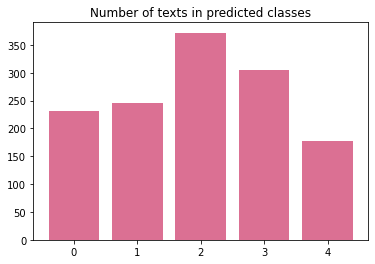

In [197]:
plt.title("Number of texts in predicted classes")
plt.bar(FreqDist(classes2).keys(), FreqDist(classes2).values(), color='palevioletred')
plt.show()

In [198]:
nmi2 = normalized_mutual_info_score(classes2, true_classes, average_method='geometric')
print('The NMI is: ', round(nmi2,2))

The NMI is:  0.73


As we can see, the NMI for KMeans increased a bit. Here lemmatization instead of stemming was used, maybe it affected the results. The data cleaning, I think, affected the results, too.

In [199]:
def top_words_per_topic(topic, classes, docs_words):
    words = []
    indices = [idx for idx, element in enumerate(classes) if element==topic]
    for idx in indices:
        words = words + docs_words[idx]
    return FreqDist(words).most_common(10)

In [200]:
print("First topic words:")
top_words_per_topic(0, classes2, texts2_stage4_1)

First topic words:


[('compiler', 438),
 ('program', 248),
 ('language', 241),
 ('code', 210),
 ('system', 174),
 ('paper', 155),
 ('graph', 149),
 ('application', 147),
 ('memory', 143),
 ('approach', 130)]

In [201]:
print("Second topic words:")
top_words_per_topic(1, classes2, texts2_stage4_1)

Second topic words:


[('security', 426),
 ('scheme', 333),
 ('quantum', 325),
 ('data', 311),
 ('proposed', 274),
 ('cryptography', 246),
 ('protocol', 233),
 ('algorithm', 232),
 ('encryption', 231),
 ('attack', 212)]

In [202]:
print("Third topic words:")
top_words_per_topic(2, classes2, texts2_stage4_1)

Third topic words:


[('image', 610),
 ('method', 536),
 ('model', 417),
 ('detection', 366),
 ('system', 338),
 ('network', 317),
 ('vision', 315),
 ('learning', 310),
 ('proposed', 305),
 ('computer', 294)]

In [203]:
print("Forth topic words:")
top_words_per_topic(3, classes2, texts2_stage4_1)

Forth topic words:


[('robot', 497),
 ('system', 438),
 ('control', 239),
 ('method', 178),
 ('robotic', 174),
 ('task', 170),
 ('model', 170),
 ('result', 166),
 ('approach', 163),
 ('study', 144)]

In [204]:
print("Fifth topic words:")
top_words_per_topic(4, classes2, texts2_stage4_1)

Fifth topic words:


[('database', 667),
 ('data', 566),
 ('relational', 312),
 ('system', 260),
 ('query', 236),
 ('information', 170),
 ('model', 155),
 ('approach', 148),
 ('paper', 105),
 ('application', 92)]

### Clustering - Spectral Clustering

In [205]:
spectral2 = SpectralClustering(n_clusters=5, random_state=2021).fit(X2)
classes2_1 = spectral2.labels_

nmi2_1 = normalized_mutual_info_score(classes2_1, true_classes, average_method='geometric')
print('The NMI is: ', round(nmi2_1,2))

The NMI is:  0.69


Spectral clustering showed worse results than the KMeans here.

Let's test next model with stemming, but with the same data cleaning.

## 2.2 Second model


### Data preprocessing

In that model the same data processing will be made, like in First model, but the stemming will be used instead of lemmatization.

Combination of title and abstract.

In [206]:
df3 = df.copy()
df3['title_text'] = df3['title'] + " " + df3['abstract']
df3.drop(['title','abstract'], axis=1, inplace=True)

Tokenization. A numpy ndarray class instance is made of the size (1332,). Where each row - a list, representing the text. It is rather convenient to operate with this matrix.

In [207]:
texts3 = pd.Series.to_numpy(df3['title_text'].apply(word_tokenize))

Removement of stopwords.

In [208]:
texts3_stage1 = []
for text in texts3:
    filtered_text = [w for w in text if not w.lower() in stop_words]
    texts3_stage1.append(filtered_text)

Stemming is performed.

In [209]:
ps1 = PorterStemmer()

texts3_stage2 = []
for text in texts3_stage1:
    stem_text = [ps1.stem(w.lower()) for w in text]
    texts3_stage2.append(stem_text)
    
texts3_stage2 = np.array(texts3_stage2, dtype=object)

Removement of numbers and deleting words with length, lower than 4.

In [210]:
texts3_stage3, texts3_stage3_1 = [], []
for text in texts3_stage2:
    nonums_text = [re.sub(r'\d+','',word) for word in text]
    nonums_text = [word for word in text if all(["http" not in word, "/" not in word])]
    nonums_text = [w for w in nonums_text if all([w, len(w)>3])]
    texts3_stage3.append(' '.join(nonums_text))
    texts3_stage3_1.append(nonums_text)

### Representation

The data is represented in tf-idf form. Sklearn offers length-normalized versions.

In [211]:
vectorizer3 = TfidfVectorizer(max_features=800, ngram_range=(1,3))
X3 = vectorizer3.fit_transform(texts3_stage3)

X3.shape

(1332, 800)

### Clustering - KMeans

In [212]:
kmeans3 = KMeans(n_clusters=5, random_state=2021).fit(X3)
classes3 = kmeans3.labels_

nmi3 = normalized_mutual_info_score(classes3, true_classes, average_method='geometric')
print('The NMI is: ', round(nmi3,2))

The NMI is:  0.76


As we can see, cleaning the words increased KMeans performance with stemming a bit. The same preprocessing with lemmatization resulted in NMI = 0.74.

As the NMI is rather high, let's check the distribution of documents per cluster.

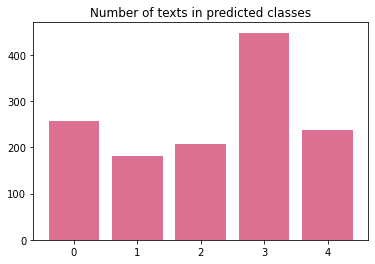

In [214]:
plt.title("Number of texts in predicted classes")
plt.bar(FreqDist(classes3).keys(), FreqDist(classes3).values(), color='palevioletred')
plt.show()

Let's try to apply PCA to plot the clustered data. Of course, the components do not explain much variance, so plotting the results cannot be interpreted as perfectly correct.

In [215]:
pca = PCA(n_components=2, random_state=2021)
pca_vecs = pca.fit_transform(X3.toarray())
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

data = pd.DataFrame()
data['cluster'] = classes3
data['x0'] = x0
data['x1'] = x1

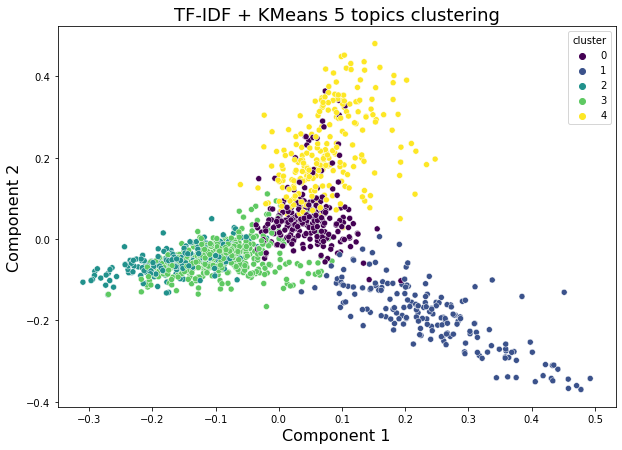

In [216]:
plt.figure(figsize=(10, 7))
plt.title("TF-IDF + KMeans 5 topics clustering", fontdict={"fontsize": 18})
plt.xlabel("Component 1", fontdict={"fontsize": 16})
plt.ylabel("Component 2", fontdict={"fontsize": 16})
sns.scatterplot(data=data, x='x0', y='x1', hue='cluster', palette="viridis")
plt.show()

### Clustering - Spectral

In [217]:
spectral3 = SpectralClustering(n_clusters=5, random_state=2021).fit(X3)
classes3_1 = spectral3.labels_

nmi3_1 = normalized_mutual_info_score(classes3_1, true_classes, average_method='geometric')
print('The NMI is: ', round(nmi3_1,2))

The NMI is:  0.73


For spectral clustering the score is lower for ~ 0.03 than for KMeans. But increased in comparison to the lemmatization in 1st modelling.

## 2.3 Third model

Here LSA is used to decrease the dimensions, and as it can be seen, it produces much better results.

In [145]:
dtm = TfidfVectorizer(ngram_range=(1,3))
dtm_mat = dtm.fit_transform(texts3_stage3)

In [146]:
dtm_mat.shape

(1332, 256385)

In [147]:
components = [25,30,35,40,45,50,75,100,125,150,175,200,225,250,275,300]
nmi_scores = []

for n in components:
    svd = TruncatedSVD(n_components=n,random_state=2021)
    # Since LSA/SVD results are not normalized, we have to redo the normalization:
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    tfidf_lsa = lsa.fit_transform(dtm_mat)
    kmeans4 = KMeans(n_clusters=5, max_iter=1000, random_state=2021)
    kmeans4.fit(tfidf_lsa)
    nmi4 = normalized_mutual_info_score(kmeans4.labels_, true_classes, average_method='geometric')
    nmi_scores.append(round(nmi4,2))
    print("Number of LSA components ", n, " has NMI: ", round(nmi4,4))

Number of LSA components  25  has NMI:  0.8172
Number of LSA components  30  has NMI:  0.7928
Number of LSA components  35  has NMI:  0.8104
Number of LSA components  40  has NMI:  0.7994
Number of LSA components  45  has NMI:  0.8149
Number of LSA components  50  has NMI:  0.8221
Number of LSA components  75  has NMI:  0.8023
Number of LSA components  100  has NMI:  0.8003
Number of LSA components  125  has NMI:  0.8014
Number of LSA components  150  has NMI:  0.7809
Number of LSA components  175  has NMI:  0.7863
Number of LSA components  200  has NMI:  0.8004
Number of LSA components  225  has NMI:  0.7865
Number of LSA components  250  has NMI:  0.7451
Number of LSA components  275  has NMI:  0.7762
Number of LSA components  300  has NMI:  0.7186


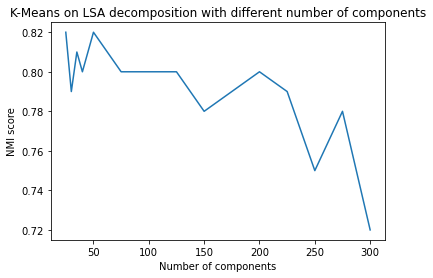

In [149]:
plt.title("K-Means on LSA decomposition with different number of components")
plt.plot(components,nmi_scores)
plt.xlabel("Number of components")
plt.ylabel("NMI score")
plt.show()

The results are better than for all the previos models. The best model is for K-Means with LSA decomposition for 50 main components.

## 3. Best model choice

In [152]:
dtm = TfidfVectorizer(ngram_range=(1,3))
dtm_mat = dtm.fit_transform(texts3_stage3)
svd = TruncatedSVD(n_components=50,random_state=2021)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
tfidf_lsa = lsa.fit_transform(dtm_mat)
kmeans5 = KMeans(n_clusters=5, max_iter=1000, random_state=2021)
kmeans5.fit(tfidf_lsa)
top_classes = kmeans5.labels_
nmi5 = normalized_mutual_info_score(kmeans5.labels_, true_classes, average_method='geometric')
print("The best achieved NMI: ", round(nmi5,4))

The best achieved NMI:  0.8221


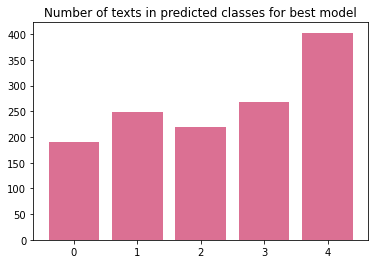

In [153]:
plt.title("Number of texts in predicted classes for best model")
plt.bar(FreqDist(top_classes).keys(), FreqDist(top_classes).values(), color='palevioletred')
plt.show()

**Most frequent words:**

In [154]:
print("First topic words:")
top_words_per_topic(0, top_classes, texts3_stage3_1)

First topic words:


[('databas', 681),
 ('data', 583),
 ('relat', 361),
 ('system', 308),
 ('queri', 270),
 ('model', 192),
 ('inform', 181),
 ('approach', 155),
 ('propos', 137),
 ('process', 133)]

In [155]:
print("Second topic words:")
top_words_per_topic(1, top_classes, texts3_stage3_1)

Second topic words:


[('secur', 676),
 ('propos', 391),
 ('scheme', 345),
 ('encrypt', 318),
 ('data', 317),
 ('algorithm', 251),
 ('cryptographi', 251),
 ('comput', 231),
 ('system', 229),
 ('protocol', 228)]

In [156]:
print("Third topic words:")
top_words_per_topic(2, top_classes, texts3_stage3_1)

Third topic words:


[('robot', 771),
 ('control', 325),
 ('system', 286),
 ('model', 169),
 ('perform', 167),
 ('propos', 143),
 ('result', 143),
 ('task', 138),
 ('develop', 128),
 ('design', 125)]

In [157]:
print("Fourth topic words:")
top_words_per_topic(3, top_classes, texts3_stage3_1)

Fourth topic words:


[('compil', 592),
 ('program', 384),
 ('comput', 300),
 ('code', 260),
 ('languag', 243),
 ('optim', 213),
 ('system', 212),
 ('gener', 181),
 ('implement', 178),
 ('paper', 174)]

In [158]:
print("Fifth topic words:")
top_words_per_topic(4, top_classes, texts3_stage3_1)

Fifth topic words:


[('imag', 618),
 ('method', 563),
 ('detect', 485),
 ('model', 470),
 ('propos', 456),
 ('comput', 388),
 ('system', 386),
 ('learn', 331),
 ('perform', 328),
 ('network', 323)]